# Import the packages

In [1]:
import pipeline as pi
from tifffile import imread,imwrite
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
from placozoan.func_segmentation import segmentation_chanvese,get_holes_mask,segmentation_otsu
from placozoan.base_features import SingleObjectFeatures
from scipy import ndimage
from skimage import exposure,img_as_ubyte,morphology,filters
from skimage.measure import label, regionprops_table

# Preprocessing

## Steps:
    
    - Increase the contrast of the image 
    - Segmenting the algae plane per plane
    - Removing them from background

In [2]:
im = imread('../data/tricho_8.tif')

In [3]:
def pre_segm(im):
    '''
    Parameters
    ----------
    im : image
        the contrast-stretched image.

    Returns
    -------
    im_final : image
        the algae present in each frames.
    Function to get the algae per plane:
    workflow:
        - segment
        - remove largest component (the organism)
        - return the segmented image 

    '''
    im_final_alg = np.zeros_like(im)
    im_final_org = np.zeros_like(im)
    
    # Preallocating mask array
    footprint = morphology.footprints.disk(1)
        
    for plane in range(np.shape(im)[0]):
        
        #print(f'Segmenting plane {plane} out of {np.shape(im)[0]}')
        print(f'{(plane/np.shape(im)[0])*100:.2f} % done ...')
        
        # Use white_tophat and gaussian filter on the frame
        image = im[plane,...]

        image = morphology.black_tophat(image, footprint)
        image = filters.gaussian(image, sigma = 2)

        # Threshold the result & label each detected region
        thresholds = filters.threshold_multiotsu(image)
        regions = np.digitize(image, bins=thresholds)
        label_image = regions

        # Fill the holes in the cell morphology
        fill = ndimage.binary_fill_holes(label_image)
        
        labels, num_features = ndimage.label(fill)
        label_unique = np.unique(labels)

        #count pixels of each component and sort them by size, excluding the background
        vol_list = []
        for labl in label_unique:
            if labl != 0:
                vol_list.append(np.count_nonzero(labels == labl))

        #create binary array of only the largest component
        binary_mask = np.zeros(labels.shape)
        binary_mask = np.where(labels == vol_list.index(max(vol_list))+1, 1, 0)

        #remove the largest component
        alg = fill - binary_mask
        org = binary_mask
        
        im_final_alg[plane,...] = alg
        im_final_org[plane,...] = org
        
    return im_final_alg,im_final_org

def stretch(im):
    '''
    Function to stretch the contrast of an image

    Parameters
    ----------
    im : image 
        raw image.

    Returns
    -------
    stretch : image
        image with stretched contrast for each planes.

    '''
    stretch = np.zeros_like(im)

    for i in range(np.shape(im)[0]):
        # Rescaling
        img = im[i,...].copy()
        p2, p98 = np.percentile(img, (2, 98))
        stretch[i,...] = exposure.rescale_intensity(img, in_range=(p2, p98))
        
    return stretch

def correct(raw_img,pre_segm,mask_alg):
    '''
    Parameters
    ----------
    mask_alg : image
        mask image of all the algae.
    raw_img : image
        the contrast stretched image.

    Returns
    -------
    new_image : image
        the corrected image: contrast-stretched image without the algae
    
    Workflow
    --------
    
    for each plane take find the algae that not below the organism by comparing the masks 
    replace the value of the algae by the mean pixel value of the image (increase contrast)

    '''
    
    #initialize the corrected raw image
    
    new_image = np.zeros_like(raw_img) 
    
    for plane in range(np.shape(raw_img)[0]):
        
        #create the mask by subtracting the algae and the environment

        mask_img = mask_alg[plane,...] * (pre_segm[plane,...] == 0.)

        #correct the image based on the substraction
        new_image[plane,...] = raw_img[plane,...] * (mask_img == 0.)
        
        #plt.imshow(new_image[plane,...])
        
        new_image[plane,...][new_image[plane,...] == 0] = np.mean(raw_img[plane,...]) # change the value of the algae by 50 (arbitrary)

    return new_image,mask_img

def preprocessing(path):
    '''
    Function to preprocess the image

    Parameters
    ----------
    path : string
        path to find the image to preprocess.

    Returns
    -------
    c : image
        the preprocessed image.
    al : image
        the algae mask.
        
    Workflow
    --------
    - Load the image
    - Stretch the contrast
    - segment the algae
    - correct the image (remove the algae)

    '''
    im = imread(path)
    im = img_as_ubyte(im[0:5,...])

    print('Presegmenting ...')
    print('--------------------------------------------------------------')
    
    al,mask = pre_segm(im)
    
    print('Done Presegmenting!')
    print('--------------------------------------------------------------')
    print('Trying to correct the image... ')
    print('--------------------------------------------------------------')
    
    c = correct(im,mask,al)
    
    print('--------------------------------------------------------------')
    print('Done with the correction!')
    print('--------------------------------------------------------------')
    print('Increasing the contrast...')
    print('--------------------------------------------------------------')
    
    img = stretch(c)
    
    print('Done with the contrast!')
    print('--------------------------------------------------------------')
    
    return img,al 

In [ ]:
preprocess,alg_mask = preprocessing('../data/new_movies/19102022_16h02_1.tif')

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
plane = 3 
ax[0].imshow(preprocess[plane,...])
ax[1].imshow(alg_mask[plane,...])

for ax in ax:
    ax.axis('off')

In [3]:
start = time.time()

In [4]:
preprocessed,alg_mask = pi.preprocessing('../data/new_movies/19102022_16h02_1.tif')

Presegmenting ...
--------------------------------------------------------------
0.00 % done ...
0.10 % done ...
0.20 % done ...
0.30 % done ...
0.40 % done ...
0.50 % done ...
0.60 % done ...
0.70 % done ...
0.80 % done ...
0.90 % done ...
1.00 % done ...
1.10 % done ...
1.20 % done ...
1.30 % done ...
1.40 % done ...
1.50 % done ...
1.60 % done ...
1.70 % done ...
1.80 % done ...
1.90 % done ...
2.00 % done ...
2.10 % done ...
2.20 % done ...
2.30 % done ...
2.40 % done ...
2.50 % done ...
2.60 % done ...
2.70 % done ...
2.80 % done ...
2.90 % done ...
3.00 % done ...
3.10 % done ...
3.20 % done ...
3.30 % done ...
3.40 % done ...
3.50 % done ...
3.60 % done ...
3.70 % done ...
3.80 % done ...
3.90 % done ...
4.00 % done ...
4.10 % done ...
4.20 % done ...
4.30 % done ...
4.40 % done ...
4.50 % done ...
4.60 % done ...
4.70 % done ...
4.80 % done ...
4.90 % done ...
5.01 % done ...
5.11 % done ...
5.21 % done ...
5.31 % done ...
5.41 % done ...
5.51 % done ...
5.61 % done ...
5.71 % 

48.45 % done ...
48.55 % done ...
48.65 % done ...
48.75 % done ...
48.85 % done ...
48.95 % done ...
49.05 % done ...
49.15 % done ...
49.25 % done ...
49.35 % done ...
49.45 % done ...
49.55 % done ...
49.65 % done ...
49.75 % done ...
49.85 % done ...
49.95 % done ...
50.05 % done ...
50.15 % done ...
50.25 % done ...
50.35 % done ...
50.45 % done ...
50.55 % done ...
50.65 % done ...
50.75 % done ...
50.85 % done ...
50.95 % done ...
51.05 % done ...
51.15 % done ...
51.25 % done ...
51.35 % done ...
51.45 % done ...
51.55 % done ...
51.65 % done ...
51.75 % done ...
51.85 % done ...
51.95 % done ...
52.05 % done ...
52.15 % done ...
52.25 % done ...
52.35 % done ...
52.45 % done ...
52.55 % done ...
52.65 % done ...
52.75 % done ...
52.85 % done ...
52.95 % done ...
53.05 % done ...
53.15 % done ...
53.25 % done ...
53.35 % done ...
53.45 % done ...
53.55 % done ...
53.65 % done ...
53.75 % done ...
53.85 % done ...
53.95 % done ...
54.05 % done ...
54.15 % done ...
54.25 % done .

96.70 % done ...
96.80 % done ...
96.90 % done ...
97.00 % done ...
97.10 % done ...
97.20 % done ...
97.30 % done ...
97.40 % done ...
97.50 % done ...
97.60 % done ...
97.70 % done ...
97.80 % done ...
97.90 % done ...
98.00 % done ...
98.10 % done ...
98.20 % done ...
98.30 % done ...
98.40 % done ...
98.50 % done ...
98.60 % done ...
98.70 % done ...
98.80 % done ...
98.90 % done ...
99.00 % done ...
99.10 % done ...
99.20 % done ...
99.30 % done ...
99.40 % done ...
99.50 % done ...
99.60 % done ...
99.70 % done ...
99.80 % done ...
99.90 % done ...
Done Presegmenting!
--------------------------------------------------------------
Trying to correct the image... 
--------------------------------------------------------------
--------------------------------------------------------------
Done with the correction!
--------------------------------------------------------------
Increasing the contrast...
--------------------------------------------------------------
Done with the contr

In [5]:
dx, dy = pi.global_drift(alg_mask)

0.00 % done ...
0.10 % done ...
0.20 % done ...
0.30 % done ...
0.40 % done ...
0.50 % done ...
0.60 % done ...
0.70 % done ...
0.80 % done ...
0.90 % done ...
1.00 % done ...
1.10 % done ...
1.20 % done ...
1.30 % done ...
1.40 % done ...
1.50 % done ...
1.60 % done ...
1.70 % done ...
1.80 % done ...
1.90 % done ...
2.00 % done ...
2.10 % done ...
2.20 % done ...
2.30 % done ...
2.40 % done ...
2.50 % done ...
2.60 % done ...
2.70 % done ...
2.80 % done ...
2.90 % done ...
3.00 % done ...
3.10 % done ...
3.20 % done ...
3.30 % done ...
3.40 % done ...
3.50 % done ...
3.60 % done ...
3.70 % done ...
3.80 % done ...
3.90 % done ...
4.00 % done ...
4.10 % done ...
4.20 % done ...
4.30 % done ...
4.40 % done ...
4.50 % done ...
4.60 % done ...
4.70 % done ...
4.80 % done ...
4.90 % done ...
5.01 % done ...
5.11 % done ...
5.21 % done ...
5.31 % done ...
5.41 % done ...
5.51 % done ...
5.61 % done ...
5.71 % done ...
5.81 % done ...
5.91 % done ...
6.01 % done ...
6.11 % done ...
6.21 % d

48.85 % done ...
48.95 % done ...
49.05 % done ...
49.15 % done ...
49.25 % done ...
49.35 % done ...
49.45 % done ...
49.55 % done ...
49.65 % done ...
49.75 % done ...
49.85 % done ...
49.95 % done ...
50.05 % done ...
50.15 % done ...
50.25 % done ...
50.35 % done ...
50.45 % done ...
50.55 % done ...
50.65 % done ...
50.75 % done ...
50.85 % done ...
50.95 % done ...
51.05 % done ...
51.15 % done ...
51.25 % done ...
51.35 % done ...
51.45 % done ...
51.55 % done ...
51.65 % done ...
51.75 % done ...
51.85 % done ...
51.95 % done ...
52.05 % done ...
52.15 % done ...
52.25 % done ...
52.35 % done ...
52.45 % done ...
52.55 % done ...
52.65 % done ...
52.75 % done ...
52.85 % done ...
52.95 % done ...
53.05 % done ...
53.15 % done ...
53.25 % done ...
53.35 % done ...
53.45 % done ...
53.55 % done ...
53.65 % done ...
53.75 % done ...
53.85 % done ...
53.95 % done ...
54.05 % done ...
54.15 % done ...
54.25 % done ...
54.35 % done ...
54.45 % done ...
54.55 % done ...
54.65 % done .

97.30 % done ...
97.40 % done ...
97.50 % done ...
97.60 % done ...
97.70 % done ...
97.80 % done ...
97.90 % done ...
98.00 % done ...
98.10 % done ...
98.20 % done ...
98.30 % done ...
98.40 % done ...
98.50 % done ...
98.60 % done ...
98.70 % done ...
98.80 % done ...
98.90 % done ...
99.00 % done ...
99.10 % done ...
99.20 % done ...
99.30 % done ...
99.40 % done ...
99.50 % done ...
99.60 % done ...
99.70 % done ...
99.80 % done ...


In [6]:
df_drift,res = pi.filtering_drift(dx,dy)

In [8]:
end = time.time() - start
print(f'The whole pipeline took {end/60:.2f} minutes to complete')

The whole pipeline took 2.71 minutes to complete


In [35]:
mask_alg,mask_org = pre_segm(im[100:150,...])

0.00 % done ...
2.00 % done ...
4.00 % done ...
6.00 % done ...
8.00 % done ...
10.00 % done ...
12.00 % done ...
14.00 % done ...
16.00 % done ...
18.00 % done ...
20.00 % done ...
22.00 % done ...
24.00 % done ...
26.00 % done ...
28.00 % done ...
30.00 % done ...
32.00 % done ...
34.00 % done ...
36.00 % done ...
38.00 % done ...
40.00 % done ...
42.00 % done ...
44.00 % done ...
46.00 % done ...
48.00 % done ...
50.00 % done ...
52.00 % done ...
54.00 % done ...
56.00 % done ...
58.00 % done ...
60.00 % done ...
62.00 % done ...
64.00 % done ...
66.00 % done ...
68.00 % done ...
70.00 % done ...
72.00 % done ...
74.00 % done ...
76.00 % done ...
78.00 % done ...
80.00 % done ...
82.00 % done ...
84.00 % done ...
86.00 % done ...
88.00 % done ...
90.00 % done ...
92.00 % done ...
94.00 % done ...
96.00 % done ...
98.00 % done ...


In [29]:
im.shape

(346, 576, 576)

In [36]:
new_img,mask_corr = correct(im[100:150,...],mask_org,mask_alg)

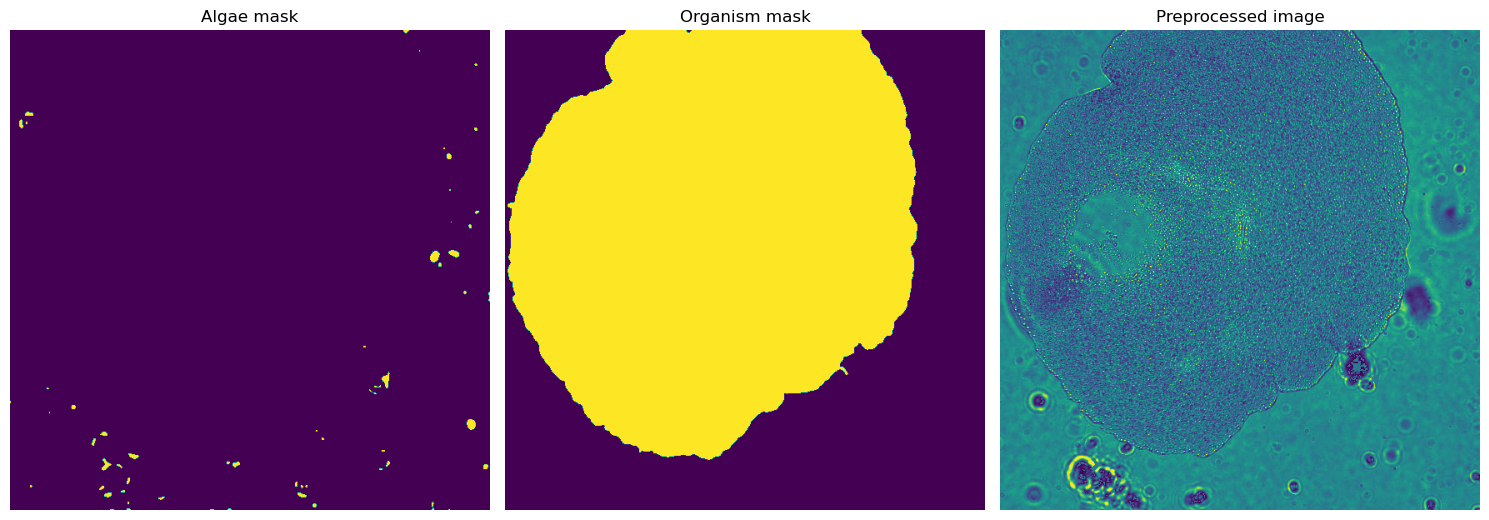

In [45]:
fig,ax = plt.subplots(1,3,figsize=(15,7))

i = 10

ax[0].imshow(mask_alg[i])
ax[1].imshow(mask_org[i])
ax[2].imshow(new_img[i])

lab = ['Algae mask','Organism mask','Preprocessed image']

for l,ax in enumerate(ax):
    ax.set_title(lab[l])
    ax.axis('off')
    
plt.tight_layout()
plt.savefig('../data/results/figures/complete_pipeline/preprocess.png',dpi=300)